In [1]:
%load_ext autotime

import os
import sys
import glob
import math
import h5py
import pandas as pd 
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm, trange
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import auc, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

## Data and Model Description

- All the models in the list were trained in HITI Server - Emory University. Training and validation data remains in the university server.
- For convience, the validation data is provided in the current folder (Bias Prediction). But one should have access to the images for running the inferences.
- Though the models were trained in the server. The models and their weights were saved and can be re-used in any machine with tf>=2.0 and tf<=2.5.
- Both validation data and the saved model are provided to run the inferences independently.

In [2]:
# Base/Parent Class
class Model():
    '''
    Class for initializing model path and data path.
    
    model_path: str
    data_path: str
    
    Note: - The model path should contain the model and it's corresponding trained weights.
          - The data path should contain the validation/test dataset and the 
            corresponding images path should be provided as required.
    '''
    def __init__(self, model_path, data_path):
        self.model_path = model_path
        self.data_path = data_path

time: 518 µs


| Model Name         | Status       | Comments     |
| :-------------     | :----------: | -----------: |
| Digital Hand Atlas | Completed    | None         |
| Mammogram          | Completed    | None         |
| CheXpert           | Completed    | Inference Mismatch|
| MIMIC-Brandon      | Completed    | None         |
| MIMIC-PoChih       | Completed    | None         |
| Cervical Spine     | Completed    | None         |
| Emory CXR          | Completed    | None         |
| MURA               | Not Completed| None         |
| Emory CT           | Not Completed| None         |
| RSPECT             | Not Completed| None         |

## To do 

1. Work on the models whose status is incomplete.
2. Check with Brandon for the inference mismatch.

In [3]:
import zipfile

with zipfile.ZipFile('./models/classification_model.zip', 'r') as zip_ref:
    zip_ref.extractall('./models/classification_model/')

time: 1.87 s


Classwise ROC AUC 

Class - Asian ROC-AUC- 0.84
Class - African-American ROC-AUC- 0.91
Class - Caucasian ROC-AUC- 0.88
Class - Hispanic ROC-AUC- 0.77
                  precision    recall  f1-score   support

           Asian       0.56      0.67      0.61        66
African-American       0.73      0.69      0.71        68
       Caucasian       0.65      0.65      0.65        68
        Hispanic       0.48      0.42      0.45        76

        accuracy                           0.60       278
       macro avg       0.60      0.61      0.60       278
    weighted avg       0.60      0.60      0.60       278

AxesSubplot(0.125,0.125;0.62x0.755)


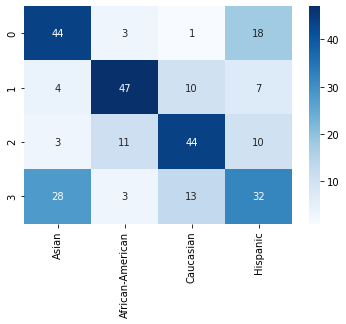

time: 57.5 s


In [4]:
# Digital Hand Atlas Class
import pickle

class Digital_Hand_Atlas_ResNet50(Model):
    def __init__(self, model_path, data_path):
        super().__init__(model_path, data_path)

    def load_data(self):
        test_data = pickle.load(open(self.data_path, 'rb'))
        X_test, y_test = test_data[0], test_data[1]
        return (X_test, y_test)

    def load_model(self):
        model = tf.keras.models.load_model(filepath=self.model_path)
        return (model)

    def calculate_inference(self):
        X_test, y_test = self.load_data()
        model = self.load_model()
        X_test = np.asarray(X_test)
        result = model.predict(X_test)
        labels = np.argmax(result, axis=1)
        target_names = ['Asian', 'African-American', 'Caucasian', 'Hispanic']
        
        print ('Classwise ROC AUC \n')
        for p in list(set(labels)):
            fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test)[:,p], pos_label = p)
            auroc = round(auc(fpr, tpr), 2)
            print ('Class - {} ROC-AUC- {}'.format(target_names[p], auroc))
        
        print (classification_report(y_test, labels, target_names=target_names))
        class_matrix = confusion_matrix(y_test, labels)
        return (sns.heatmap(class_matrix, annot=True, fmt='d', xticklabels=target_names, cmap='Blues'))

dha = Digital_Hand_Atlas_ResNet50(model_path='./models/classification_model/', data_path='./test_data/test_data_dha.pkl')
print (dha.calculate_inference())

Found 17201 validated image filenames belonging to 2 classes.
Classwise ROC AUC 

Class - 0 ROC-AUC- 0.88
Class - 1 ROC-AUC- 0.88
                           precision    recall  f1-score   support

African American or Black       0.84      0.69      0.75      8487
       Caucasian or White       0.74      0.87      0.80      8714

                 accuracy                           0.78     17201
                macro avg       0.79      0.78      0.78     17201
             weighted avg       0.79      0.78      0.78     17201

AxesSubplot(0.125,0.125;0.62x0.755)


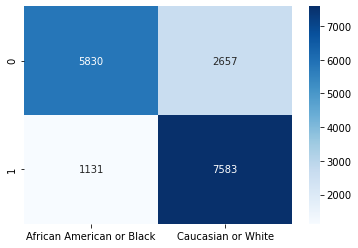

time: 17min 1s


In [4]:
# Mammogram Class
import efficientnet.tfkeras as efn
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

class Mammogram_EfficientNet(Model):
    def __init__(self, model_path, data_path):
        self.model_path = model_path
        self.data_path = data_path

    def load_data(self, img_height, img_width, batch_size):
        validation_df = pd.read_csv(self.data_path)
        validation_df['modified_png_path'] = [0]*len(validation_df)
        for i in range(len(validation_df)):
            validation_df['modified_png_path'][i] = validation_df['png_path'][i][20:]
        
        validate_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
        validate_batches = validate_gen.flow_from_dataframe(validation_df,directory=None,
                                                            x_col='modified_png_path', y_col='ETHNICITY_DESC',
                                                            class_mode='categorical', 
                                                            target_size=(img_height, img_width), 
                                                            shuffle=False,
                                                            batch_size=batch_size, dtype='float32')
        val_epoch = math.ceil(len(validation_df)/batch_size)
        return (validate_batches, val_epoch)

    def load_model(self):
        model = tf.keras.models.load_model(self.model_path)
        return (model)

    def calculate_inference(self, img_height, img_width, batch_size):
        validate_batches, val_epoch = self.load_data(img_height=img_height, 
                                                     img_width=img_width, batch_size=batch_size)
        model = self.load_model()

        result = model.predict(validate_batches, val_epoch)
        labels = np.argmax(result, axis=1)
        target_names = ['African American or Black', "Caucasian or White"]
        
        print ('Classwise ROC AUC \n')
        for p in list(set(labels)):
            fpr, tpr, thresholds = roc_curve(validate_batches.classes, result[:,p], pos_label = p)
            auroc = round(auc(fpr, tpr), 2)
            print ('Class - {} ROC-AUC- {}'.format(p, auroc))
            
        print (classification_report(validate_batches.classes, labels, target_names=target_names))
        class_matrix = confusion_matrix(validate_batches.classes, labels)
        return (sns.heatmap(class_matrix, annot=True, fmt='d', xticklabels=target_names, cmap='Blues'))

mma = Mammogram_EfficientNet(model_path='./models/mammo_efficientnetB2_binary.hdf5', 
                             data_path='./test_data/mammo_test.csv')
print (mma.calculate_inference(img_height=256, img_width=256, batch_size=32))

100%|██████████| 38386/38386 [00:15<00:00, 2443.78it/s]


Found 38386 validated image filenames belonging to 3 classes.
Classwise ROC AUC 

Class - 0 ROC-AUC - 0.77
Class - 1 ROC-AUC - 0.53
Class - 2 ROC-AUC - 0.76
              precision    recall  f1-score   support

           0       0.31      0.88      0.46      5626
           1       0.96      0.07      0.13      2509
           2       0.94      0.69      0.79     30251

    accuracy                           0.68     38386
   macro avg       0.74      0.55      0.46     38386
weighted avg       0.85      0.68      0.70     38386

AxesSubplot(0.125,0.125;0.62x0.755)


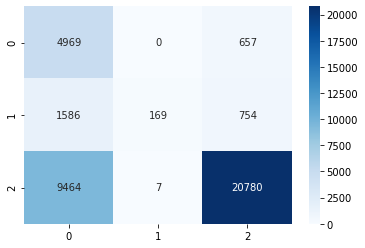

time: 1h 8min 47s


In [5]:
# CheXpert Class 
from tensorflow import keras
from classification_models.tfkeras import Classifiers

class CheXpert_B_ResNet34(Model):
    def __init__(self, model_path, data_path):
        self.model_path = model_path
        self.data_path = data_path
        
    def load_data(self, img_width, img_height, batch_size):
        validation_df = pd.read_csv(self.data_path)
        validation_df['modified_path'] = [0]*len(validation_df)
        for i in trange(len(validation_df)):
            validation_df['modified_path'][i] = '/data/DataCenter/'+validation_df['Path'][i]

        resnet34, preprocess_input = Classifiers.get('resnet34')
        validate_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
        validate_batches = validate_gen.flow_from_dataframe(validation_df,
                                                            directory=None,
                                                            x_col='modified_path', y_col='race', 
                                                            class_mode='categorical',
                                                            target_size=(img_height, img_width), shuffle=False,
                                                            batch_size=batch_size, dtype='float32')
        val_epoch = math.ceil(len(validation_df)/batch_size)
        return (validate_batches, val_epoch)

    
    def load_model(self):
        model = tf.keras.models.load_model(self.model_path)
        return (model)
    
    def calculate_inference(self, img_width, img_height, batch_size):
        validate_batches, val_epoch = self.load_data(img_width=img_width, img_height=img_height, 
                                                     batch_size=batch_size)
        model = self.load_model()
        
        result = model.predict(validate_batches, val_epoch)
        labels = np.argmax(result, axis=1)
        
        classes_cat = tf.keras.utils.to_categorical(validate_batches.classes)
        labels_cat = tf.keras.utils.to_categorical(labels)
        
        print ('Classwise ROC AUC \n')
        for i in range(len(list(set(labels)))):
            _classes = classes_cat[:,i]
            _labels = labels_cat[:,i]
            print ('Class - {} ROC-AUC - {}'.format(i, round(roc_auc_score(_classes, _labels), 2)))
        
        print (classification_report(validate_batches.classes, labels))
        class_matrix = confusion_matrix(validate_batches.classes, labels)
        return (sns.heatmap(class_matrix, annot=True, fmt='d', cmap='Blues'))
    
cxr = CheXpert_B_ResNet34(model_path='./models/CHEXPERT_race_classification.hdf5', 
                          data_path='./test_data/chexpert_test_df.csv')
print (cxr.calculate_inference(img_height=320, img_width=320, batch_size=256))

100%|██████████| 58614/58614 [00:32<00:00, 1780.25it/s]


Found 58614 validated image filenames belonging to 3 classes.
Classwise ROC AUC 

Class - 0 ROC-AUC- 0.93
Class - 1 ROC-AUC- 0.95
Class - 2 ROC-AUC- 0.94
              precision    recall  f1-score   support

           0       0.56      0.49      0.52      2220
           1       0.96      0.52      0.68     10637
           2       0.89      0.99      0.93     45757

    accuracy                           0.88     58614
   macro avg       0.80      0.67      0.71     58614
weighted avg       0.89      0.88      0.87     58614

AxesSubplot(0.125,0.125;0.62x0.755)


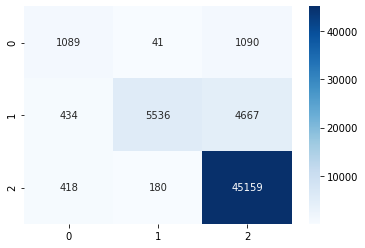

time: 1h 47min 22s


In [6]:
# MIMIC Class - Brandon
class MIMIC_B_ResNet34(Model):
    def __init__(self, model_path, data_path):
        self.model_path = model_path
        self.data_path = data_path
        
    def load_data(self, img_width, img_height, batch_size):
        validation_df = pd.read_csv(self.data_path)
        validation_df['modified_path'] = [0]*len(validation_df)
        for i in trange(len(validation_df)):
            validation_df['modified_path'][i] = '/data/DataCenter/MIMIC-CXR/files/p'+validation_df['path'][i]

        resnet34, preprocess_input = Classifiers.get('resnet34')
        validate_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
        validate_batches = validate_gen.flow_from_dataframe(validation_df,
                                                            directory= None, #'/tf/notebooks/SSD_data/resize_chexpert_320x320/chexpert_data/',
                                                            x_col='modified_path', y_col='race', 
                                                            class_mode='categorical',
                                                            target_size=(img_height, img_width), shuffle=False,
                                                            batch_size=batch_size, dtype='float32')
        val_epoch = math.ceil(len(validation_df)/batch_size)
        return (validate_batches, val_epoch)

    
    def load_model(self):
        model = tf.keras.models.load_model(self.model_path)
        return (model)
    
    def calculate_inference(self, img_width, img_height, batch_size):
        validate_batches, val_epoch = self.load_data(img_width=img_width, img_height=img_height, 
                                                     batch_size=batch_size)
        model = self.load_model()
        
        result = model.predict(validate_batches, val_epoch)
        labels = np.argmax(result, axis=1)
        
        print ('Classwise ROC AUC \n')
        for p in list(set(labels)):
            fpr, tpr, thresholds = roc_curve(validate_batches.classes, result[:,p], pos_label = p)
            auroc = round(auc(fpr, tpr), 2)
            print ('Class - {} ROC-AUC- {}'.format(p, auroc))
        
        print (classification_report(validate_batches.classes, labels))
        class_matrix = confusion_matrix(validate_batches.classes, labels)
        return (sns.heatmap(class_matrix, annot=True, fmt='d', cmap='Blues'))

mmcb = MIMIC_B_ResNet34(model_path='./models/MIMIC_CXR_race_classification.hdf5', 
                        data_path='./test_data/mimic_test_df.csv')
print (mmcb.calculate_inference(img_height=320, img_width=320, batch_size=32))

100%|██████████| 2/2 [00:00<00:00, 6700.17it/s]


100%|██████████| 14714/14714 [00:00<00:00, 22822.54it/s]


Classwise ROC AUC 

Class - 0 ROC-AUC- 0.94
Class - 1 ROC-AUC- 0.95
Class - 2 ROC-AUC- 0.84
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      9552
           1       0.94      0.71      0.81      4050
           2       0.94      0.17      0.29      1112

    accuracy                           0.85     14714
   macro avg       0.90      0.62      0.67     14714
weighted avg       0.87      0.85      0.83     14714

AxesSubplot(0.125,0.125;0.62x0.755)


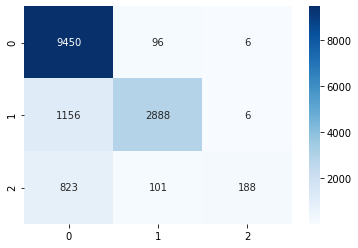

time: 11min 38s


In [7]:
# MIMIC Class - PoChih
from classification_models.tfkeras import Classifiers
import cv2 as cv
import skimage.transform as st

class MIMIC_P_DenseNet121(Model):
    def __init__(self, model_path, data_path):
        self.model_path = model_path
        self.data_path = data_path
        
    def load_data(self):
        X_test = []
        y_test = []
        
        filename = os.listdir(self.data_path)
        for i in trange(len(filename)):
            filename[i] = self.data_path+filename[i]
        
        raw_dataset = tf.data.TFRecordDataset(filename)
        for raw_record in raw_dataset:
            sub_y = []

            example = tf.train.Example()
            example.ParseFromString(raw_record.numpy())

            ethnicity = example.features.feature['ethnicity'].int64_list.value[0]   
            id = example.features.feature['subject_id'].int64_list.value[0]
            
            if (tf.math.equal(ethnicity, 0)):
                label = tf.constant([1, 0, 0])
            elif (tf.math.equal(ethnicity, 1)):
                label = tf.constant([0, 1, 0])
            elif (tf.math.equal(ethnicity, 4)):
                label = tf.constant([0, 0, 1])
            else:
                continue

            nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)
            img_np = cv.imdecode(nparr, cv.IMREAD_GRAYSCALE)
            X_test.append(tf.reshape(st.resize(img_np, (256, 256)), [256, 256, 1]))
            y_test.append(label)

        return np.array(X_test), np.array(y_test)

    def load_model(self):
        model = tf.keras.models.load_model(self.model_path)
        return (model)
    
    def calculate_inference(self, img_width, img_height, batch_size):
        modified_y_test = []
        X_test, y_test = self.load_data()
        model = self.load_model()
        
        result = model.predict(X_test)
        labels = np.argmax(result, axis=1)
        
        for i in trange(len(y_test)):
            if (np.array_equal([1, 0, 0], y_test[i])):
                modified_y_test.append(0)
            if (np.array_equal([0, 1, 0], y_test[i])):
                modified_y_test.append(1)
            if (np.array_equal([0, 0, 1], y_test[i])):
                modified_y_test.append(2)
        
        print ('Classwise ROC AUC \n')
        for p in list(set(labels)):
            fpr, tpr, thresholds = roc_curve(modified_y_test, result[:,p], pos_label = p)
            auroc = round(auc(fpr, tpr), 2)
            print ('Class - {} ROC-AUC- {}'.format(p, auroc))
        
        print (classification_report(modified_y_test, labels))
        class_matrix = confusion_matrix(modified_y_test, labels)
        return (sns.heatmap(class_matrix, annot=True, fmt='d', cmap='Blues'))

mmcp = MIMIC_P_DenseNet121(model_path='./models/Dnet_race_WBA/', 
                           data_path='./test_data/test_mimic_pochih/')
print (mmcp.calculate_inference(img_height=256, img_width=256, batch_size=32))

100%|██████████| 945/945 [00:00<00:00, 9860.95it/s]


Found 945 validated image filenames belonging to 2 classes.
Classwise ROC AUC 

Class - 0 ROC-AUC- 0.92
Class - 1 ROC-AUC- 0.92
              precision    recall  f1-score   support

           0       0.82      0.68      0.74       286
           1       0.87      0.93      0.90       659

    accuracy                           0.86       945
   macro avg       0.85      0.81      0.82       945
weighted avg       0.86      0.86      0.85       945

AxesSubplot(0.125,0.125;0.62x0.755)


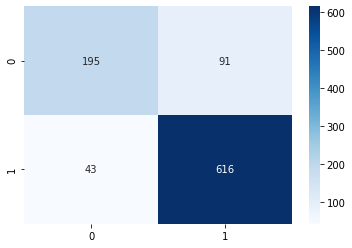

time: 1min 21s


In [8]:
# Cervical Spine Class
class C_Spine_ResNet34(Model):
    def __init__(self, model_path, data_path):
        self.model_path = model_path
        self.data_path = data_path
        
    def load_data(self, img_width, img_height, batch_size):
        validation_df = pd.read_csv(self.data_path)
        validation_df = validation_df[validation_df.Race.isin(['African American  or Black', 'Caucasian or White'])]
        validation_df['modified_path'] = [0]*len(validation_df)
        for i in trange(len(validation_df)):
            validation_df['modified_path'][i] = validation_df['Image'][i][2:]
            
        resnet34, preprocess_input = Classifiers.get('resnet34')
        
        validate_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
        validate_batches = validate_gen.flow_from_dataframe(validation_df,
                                                            directory= None, #'/tf/notebooks/SSD_data/resize_chexpert_320x320/chexpert_data/',
                                                            x_col='modified_path', y_col='Race', 
                                                            class_mode='categorical',
                                                            target_size=(img_height, img_width), shuffle=False,
                                                            batch_size=batch_size, dtype='float32')
        val_epoch = math.ceil(len(validation_df)/batch_size)
        return (validate_batches, val_epoch)

    
    def load_model(self):
        model = tf.keras.models.load_model(self.model_path)
        return (model)
    
    def calculate_inference(self, img_width, img_height, batch_size):
        validate_batches, val_epoch = self.load_data(img_width=img_width, img_height=img_height, 
                                                     batch_size=batch_size)
        model = self.load_model()
        
        result = model.predict(validate_batches, val_epoch)
        labels = np.argmax(result, axis=1)
        
        print ('Classwise ROC AUC \n')
        for p in list(set(labels)):
            fpr, tpr, thresholds = roc_curve(validate_batches.classes, result[:,p], pos_label = p)
            auroc = round(auc(fpr, tpr), 2)
            print ('Class - {} ROC-AUC- {}'.format(p, auroc))
        
        print (classification_report(validate_batches.classes, labels))
        class_matrix = confusion_matrix(validate_batches.classes, labels)
        return (sns.heatmap(class_matrix, annot=True, fmt='d', cmap='Blues'))

cspine = C_Spine_ResNet34(model_path='./models/EMORY_C-Spine_race_classification.hdf5', 
                          data_path='./test_data/emory_c-spine_lateral_dataset_test.csv')
print (cspine.calculate_inference(img_height=320, img_width=320, batch_size=64))

Found 11832 validated image filenames belonging to 3 classes.
Classwise ROC AUC 

Class - 0 ROC-AUC- 0.97
Class - 1 ROC-AUC- 0.99
Class - 2 ROC-AUC- 0.99
              precision    recall  f1-score   support

           0       0.76      0.63      0.69       484
           1       0.98      0.97      0.97      6067
           2       0.94      0.96      0.95      5281

    accuracy                           0.95     11832
   macro avg       0.89      0.85      0.87     11832
weighted avg       0.95      0.95      0.95     11832

AxesSubplot(0.125,0.125;0.62x0.755)


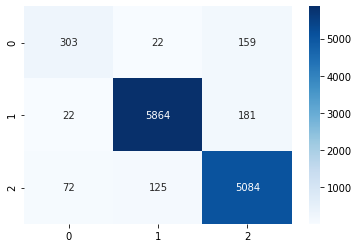

time: 19min 10s


In [10]:
# Emory CXR Class
class Emory_CXR_ResNet34(Model):
    def __init__(self, model_path, data_path):
        self.model_path = model_path
        self.data_path = data_path
        
    def load_data(self, img_width, img_height, batch_size):
        validation_df = pd.read_csv(self.data_path)
        validation_df = validation_df[validation_df.Race.isin(['ASIAN','BLACK/AFRICAN AMERICAN','WHITE'])]
        validation_df = validation_df[~validation_df.hiti_path.str.contains('406e0996e5f1cf082487d7d096574d10b46c0c52710222a4884db1cc|dd97e997cc2a4166dc6e192cb62e29553aa28f4671d98c9577e32cfd|6224290209c45bb2b3e07b3b3a27778d1d10f7953567b3c59158e099')]
            
        resnet34, preprocess_input = Classifiers.get('resnet34')
        
        validate_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
        validate_batches = validate_gen.flow_from_dataframe(validation_df,
                                                            directory= None, #'/tf/notebooks/SSD_data/resize_chexpert_320x320/chexpert_data/',
                                                            x_col='hiti_path', y_col='Race', 
                                                            class_mode='categorical',
                                                            target_size=(img_height, img_width), shuffle=False,
                                                            batch_size=batch_size, dtype='float32')
        val_epoch = math.ceil(len(validation_df)/batch_size)
        return (validate_batches, val_epoch)

    
    def load_model(self):
        model = tf.keras.models.load_model(self.model_path)
        return (model)
    
    def calculate_inference(self, img_width, img_height, batch_size):
        validate_batches, val_epoch = self.load_data(img_width=img_width, img_height=img_height, 
                                                     batch_size=batch_size)
        model = self.load_model()
        
        result = model.predict(validate_batches, val_epoch)
        labels = np.argmax(result, axis=1)
        
        print ('Classwise ROC AUC \n')
        for p in list(set(labels)):
            fpr, tpr, thresholds = roc_curve(validate_batches.classes, result[:,p], pos_label = p)
            auroc = round(auc(fpr, tpr), 2)
            print ('Class - {} ROC-AUC- {}'.format(p, auroc))
        
        print (classification_report(validate_batches.classes, labels))
        class_matrix = confusion_matrix(validate_batches.classes, labels)
        return (sns.heatmap(class_matrix, annot=True, fmt='d', cmap='Blues'))

ecxr = Emory_CXR_ResNet34(model_path='./models/EMORY_CXR_race_classification.hdf5', 
                          data_path='./test_data/Emory_CXR_test_censored.csv')
print (ecxr.calculate_inference(img_height=320, img_width=320, batch_size=64))